In [1]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import tiktoken
import torch
import torch.nn as nn

/var/folders/z2/36ffzbvd28g36r8g2fdb9ncw0000gn/T/ipykernel_66366/1307445776.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Hyperparameters
batch_size = 4  # How many batches per training step
context_length = 16  # Length of the token chunk each batch
d_model = 64  # The vector size of the token embeddings
num_layers = 8  # Number of transformer blocks
num_heads = 4  # Number of heads in Multi-head attention # 我们的代码中通过 d_model / num_heads = 来获取 head_size
learning_rate = 1e-3  # 0.001
dropout = 0.1 # Dropout rate
max_iters = 500  # Total of training iterations
eval_interval = 50  # How often to evaluate the model 
eval_iters = 20  # How many iterations to average the loss over when evaluating the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Instead of using the cpu, we'll use the GPU if it's available.

TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

In [3]:
# download a sample txt file from https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt
if not os.path.exists('sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt'
    with open('sales_textbook.txt', 'w') as f:
        f.write(requests.get(url).text)

with open('sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    

In [4]:
# Using TikToken to tokenize the source text
encoding = tiktoken.get_encoding("cl100k_base")
tokenized_text = encoding.encode(text) # size of tokenized source text is 77,919
vocab_size = len(set(tokenized_text)) # size of vocabulary is 3,771
max_token_value = max(tokenized_text)

print(f"Tokenized text size: {len(tokenized_text)}")
print(f"Vocabulary size: {vocab_size}")
print(f"The maximum value in the tokenized text is: {max_token_value}")


Tokenized text size: 77919
Vocabulary size: 3771
The maximum value in the tokenized text is: 100069


In [5]:
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long, device=device) #将77,919个tokens 转换到Pytorch张量中
len(tokenized_text)

77919

In [6]:
# Illustration purpose
print(encoding.encode('Chapter 1: Building Rapport and Capturing'))
print(encoding.decode([26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711])) # "Rapport" is tokenized as two tokens: "Rap"[23097] and "port"[403]
print(encoding.decode([  627,  1383, 88861,   279,  1989,   315, 25607, 16940, 65931,   323,
                         32097,    11,   584, 26458, 13520,   449]))

[26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711]
Chapter 1: Building Rapport and Capturing
.
By mastering the art of identifying underlying motivations and desires, we equip ourselves with


In [7]:
# Split train and validation
split_idx = int(len(tokenized_text) * 0.8)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]

In [8]:
# Prepare data for training batch
data = train_data
idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))
x_batch = torch.stack([data[idx:idx + context_length] for idx in idxs])
y_batch = torch.stack([data[idx + 1:idx + context_length + 1] for idx in idxs])
print(x_batch.shape, x_batch.shape)

torch.Size([4, 16]) torch.Size([4, 16])


In [9]:
xx = x_batch.data.detach().cpu().numpy()
pd.set_option('display.expand_frame_repr', False)
print("Our batches:\n", pd.DataFrame(xx))


Our batches:
       0     1      2      3     4      5      6      7      8      9      10     11     12     13     14     15
0    627  1383  88861    279  1989    315  25607  16940  65931    323  32097     11    584  26458  13520    449
1  15749   311   9615   3619   872   6444      6   3966     11  10742     11    323  32097     13   3296  22815
2  13189   315   1701   5557   304   6763    374  88861   7528  10758   7526     13   4314   7526   2997   2613
3    323  6376   2867  26470  1603  16661    264  49148    627     18     13  81745  48023  75311   7246  66044


In [10]:
# Define Token Embedding look-up table
token_embedding_lookup_table = nn.Embedding(max_token_value, d_model)
print("Token Embedding Look-up table: ", token_embedding_lookup_table)

Token Embedding Look-up table:  Embedding(100069, 64)


In [11]:
# Get x and y embedding
x = token_embedding_lookup_table(x_batch.data) # [4, 16, 64] [batch_size, context_length, d_model]
y = token_embedding_lookup_table(y_batch.data)

In [12]:
# Define Position Encoding look-up table
position_encoding_lookup_table = torch.zeros(context_length, d_model)
position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)
position_encoding_lookup_table = position_encoding_lookup_table.unsqueeze(0).expand(batch_size, -1, -1) #add batch dimension

print("Position Encoding Look-up Table: ", position_encoding_lookup_table.shape)
print(torch.round(position_encoding_lookup_table * 100)/100)

Position Encoding Look-up Table:  torch.Size([4, 16, 64])
tensor([[[ 0.0000,  1.0000,  0.0000,  ...,  1.0000,  0.0000,  1.0000],
         [ 0.8400,  0.5400,  0.6800,  ...,  1.0000,  0.0000,  1.0000],
         [ 0.9100, -0.4200,  1.0000,  ...,  1.0000,  0.0000,  1.0000],
         ...,
         [ 0.4200,  0.9100, -0.3200,  ...,  1.0000,  0.0000,  1.0000],
         [ 0.9900,  0.1400, -0.8800,  ...,  1.0000,  0.0000,  1.0000],
         [ 0.6500, -0.7600, -0.9700,  ...,  1.0000,  0.0000,  1.0000]],

        [[ 0.0000,  1.0000,  0.0000,  ...,  1.0000,  0.0000,  1.0000],
         [ 0.8400,  0.5400,  0.6800,  ...,  1.0000,  0.0000,  1.0000],
         [ 0.9100, -0.4200,  1.0000,  ...,  1.0000,  0.0000,  1.0000],
         ...,
         [ 0.4200,  0.9100, -0.3200,  ...,  1.0000,  0.0000,  1.0000],
         [ 0.9900,  0.1400, -0.8800,  ...,  1.0000,  0.0000,  1.0000],
         [ 0.6500, -0.7600, -0.9700,  ...,  1.0000,  0.0000,  1.0000]],

        [[ 0.0000,  1.0000,  0.0000,  ...,  1.0000,  0.000

In [13]:
# Illustration Purpose Only
token_embedding_lookup_table_np = token_embedding_lookup_table.weight.data.detach().cpu().numpy() # Convert into a numpy array
token_embedding_lookup_table_np = pd.DataFrame(token_embedding_lookup_table_np)
print("Token Embedding Look-Up Table:\n", token_embedding_lookup_table_np)

Token Embedding Look-Up Table:
               0         1         2         3         4         5         6         7         8         9   ...        54        55        56        57        58        59        60        61        62        63
0       0.625765  0.025510  0.954514  0.064349 -0.502401 -0.202555 -1.567081 -1.097956  0.235958 -0.239778  ...  0.420812  0.277596  0.778898  1.533269  1.609736 -0.403228 -0.274928  1.473840  0.068826  1.332708
1      -0.497006  0.465756 -0.257259 -1.067259  0.835319 -1.956048 -0.800265 -0.504499 -1.426664  0.905942  ...  0.008287 -0.252325 -0.657626  0.318449 -0.549586 -1.464924 -0.557690 -0.693927 -0.325247  1.243933
2       1.347121  1.690980 -0.124446 -1.682366  1.134614 -0.082384  0.289316  0.835773  0.306655 -0.747233  ...  0.543340 -0.843840 -0.687481  2.138219  0.511412  1.219090  0.097527 -0.978587 -0.432050 -1.493750
3       1.078523 -0.614952 -0.458853  0.567482  0.095883 -1.569957  0.373957 -0.142067 -1.242306 -0.961821  ... -0.88244

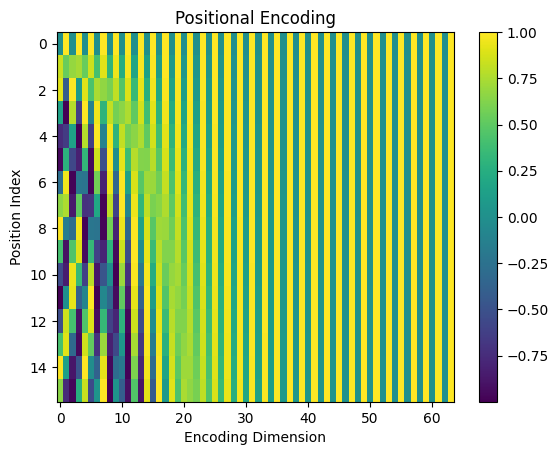

In [14]:
# Illustration Purpose Only
def visualize_pe(pe):
    plt.imshow(pe, aspect="auto")
    plt.title("Positional Encoding")
    plt.xlabel("Encoding Dimension")
    plt.ylabel("Position Index")
    plt.colorbar()
    plt.show()

position_encoding_lookup_table2_np = position_encoding_lookup_table[0].cpu().numpy()
visualize_pe(position_encoding_lookup_table2_np)

In [15]:
# Add positional encoding into the input embedding vector
input_embedding_x = x + position_encoding_lookup_table # [4, 16, 64] [batch_size, context_length, d_model]
input_embedding_y = y + position_encoding_lookup_table
x_plot = input_embedding_x[0].detach().cpu().numpy()
print("Final Input Embedding of x: \n", pd.DataFrame(x_plot))

Final Input Embedding of x: 
           0         1         2         3         4         5         6         7         8         9   ...        54        55        56        57        58        59        60        61        62        63
0   0.346711  0.416130  0.194183  2.676231  0.104132  0.317640 -0.716680  2.721329 -1.379066  1.958478  ...  0.326141  0.918822 -0.974995  0.776366 -1.208963  1.784498  0.213160  2.055345  0.838057  0.250892
1   0.115021  0.819889  1.295355  0.050067  1.152808  0.007295  2.096463  1.836589 -1.455025  2.047307  ...  0.434175  1.833931 -0.511320  1.208292  0.141251  2.429123  0.510447  1.479065  1.451683  0.670747
2   0.025032 -0.896510  2.007128  0.645062  1.861388  1.183611  0.626595  0.867692  0.332192  0.616423  ...  0.095568 -0.311354 -1.522920  1.861448 -0.841794  1.096748 -1.112153  1.676283  1.079349  1.205097
3   1.540862 -2.196910  1.106263 -0.879057  1.525127 -0.364159  1.305572 -0.088271  0.942626 -0.624826  ... -0.546487  2.515671  1.224692 

In [16]:
# Prepare Query, Key, Value for Multi-head Attention
X = input_embedding_x
query = key = value = X # [4, 16, 64] [batch_size, context_length, d_model]
query.shape

torch.Size([4, 16, 64])

In [17]:
# Define Query, Key, Value weight matrices
Wq = nn.Linear(d_model, d_model)
Wk = nn.Linear(d_model, d_model)
Wv = nn.Linear(d_model, d_model)

Q = Wq(query) #[4, 16, 64]
Q = Q.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

K = Wk(key) #[4, 16, 64]
K = K.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

V = Wv(value) #[4, 16, 64]
V = V.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

# print(torch.round(Q[0] * 100) / 100)
qqq = Q.detach().cpu().numpy()
for qs in qqq:
    for qss in qs:
        print(pd.DataFrame(qss))

print(Q.shape) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]

         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0 -1.025968  0.133713 -0.187217 -0.199014 -1.527093 -0.764418  0.282691 -0.772156  0.562685  0.619130  0.922693 -0.161524 -0.641406 -1.242846 -0.130296  0.002646
1 -0.623791 -0.345467 -0.205378 -0.234110 -0.274661  0.106249 -1.698619  1.065493  0.135303 -0.610848 -0.924096  0.105887  0.106972 -0.315460 -0.959068 -0.527901
2  0.100559  0.404248  0.404759 -0.900741  0.413372  0.409686  0.773026  0.385371 -0.025313 -0.373410  0.827897 -1.059960 -0.802082  1.004370  0.257020 -0.007169
3  0.426449  0.023799  0.089837 -0.680759 -0.317915 -0.271844  0.339102 -1.243521  0.260243 -0.885803 -0.819325 -0.508406 -0.316238 -0.928699 -0.365961 -0.636015
         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0 -0.750633  0.317580 -0.684

In [18]:
# Transpose q,k,v from [batch_size, context_length, num_heads, head_size] to [batch_size, num_heads, context_length, head_size]
# The reason is that treat each batch with "num_heads" as its first dimension.
Q = Q.transpose(1, 2) # [4, 4, 16, 16]
K = K.transpose(1, 2) # [4, 4, 16, 16]
V = V.transpose(1, 2) # [4, 4, 16, 16]

torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])
          0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0   0.271247  0.560849 -0.497451 -0.129847 -0.363947 -0.685937  0.185218 -0.109630 -0.582609 -0.399922 -0.526987  0.009846  0.095429 -0.417190 -0.294367  0.189911
1  -0.045627  0.335207 -0.261123  0.401420 -0.060368  0.060264  0.264576  0.356827  0.278763 -0.405287  0.052244 -0.403992  0.486559  0.041878  1.014870  0.202047
2  -0.062706  0.149768 -0.373623 -0.014540  0.501353  0.051065  0.528086 -0.215684 -0.363876 -0.507898 -0.526590 -1.015162  0.636724 -0.353700  0.629859  0.337414
3   0.489974  0.889258 -0.396356  0.726592  0.525897 -0.280680 -0.086416 -0.236879 -0.139481  0.180077  0.160038 -0.278772  0.029830  0.025996  0.100336 -0.437344
4   0.366094  0.809745  0.008297  0.004744  0.321938 -0.265212 -0.031628  0.000414 -0.327081  0.007050  0.058440  0.219607  0.31196

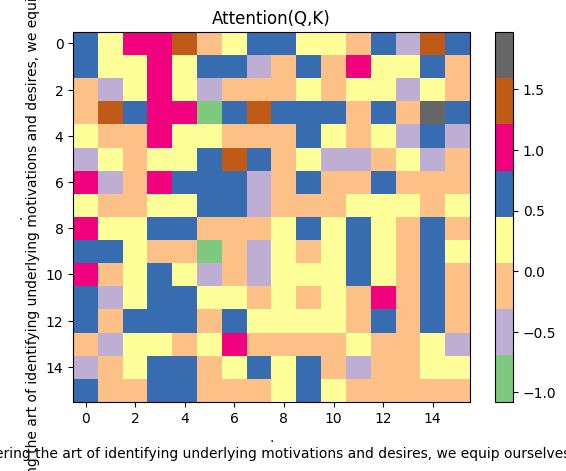

In [19]:
# Calculate the attention score
print(Q.shape)
print(K.shape)
attention_score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_model // num_heads) # [4, 4, 16, 16]
print(pd.DataFrame(attention_score[0][0].detach().cpu().numpy()))
# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q,K)")
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()

          0         1         2         3         4         5         6         7         8         9         10        11        12        13        14       15
0   0.271247      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf     -inf
1  -0.045627  0.335207      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf     -inf
2  -0.062706  0.149768 -0.373623      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf     -inf
3   0.489974  0.889258 -0.396356  0.726592      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf     -inf
4   0.366094  0.809745  0.008297  0.004744  0.321938      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf      -inf     -inf
5   0.086671  0.772399 -0.76

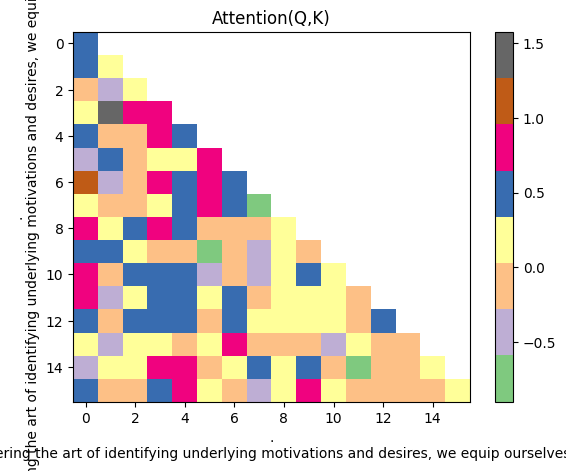

In [20]:
# Apply Mask to attention scores
attention_score = attention_score.masked_fill(torch.triu(torch.ones(attention_score.shape[-2:]), diagonal=1).bool(), float('-inf'))#[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
print(pd.DataFrame(attention_score[0][0].detach().cpu().numpy()))
# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q,K)")
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()

In [21]:
# Softmax the attention score
attention_score = torch.softmax(attention_score, dim=-1) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
print(pd.DataFrame(attention_score[0][0].detach().cpu().numpy()))

          0         1         2         3         4         5         6         7         8         9         10        11        12        13        14       15
0   1.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000
1   0.405926  0.594074  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000
2   0.336756  0.416478  0.246766  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000
3   0.239815  0.357506  0.098843  0.303835  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000
4   0.203619  0.317316  0.142373  0.141868  0.194823  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000
5   0.139601  0.277139  0.05

In [22]:
# Calculate the V attention output
print(attention_score.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
print(V.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
A = torch.matmul(attention_score, V) # [4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
print(A.shape)

torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])


In [23]:
# Concatenate the attention output
A = A.transpose(1, 2) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]
A = A.reshape(batch_size, -1, d_model) # [4, 16, 64] [batch_size, context_length, d_model]
print(A)

tensor([[[ 2.2984e-01,  1.0711e-01, -4.7054e-01,  ...,  1.9655e+00,
          -1.2104e+00,  4.0954e-01],
         [ 3.8354e-01,  1.2461e-01, -4.9296e-01,  ...,  1.6057e+00,
          -8.4324e-01,  2.7363e-01],
         [ 4.0751e-01, -5.8964e-02, -5.7771e-01,  ...,  1.3481e+00,
          -6.6691e-01,  2.9795e-01],
         ...,
         [ 5.8758e-01, -8.5848e-03, -3.8717e-01,  ...,  4.6530e-01,
          -1.3207e-01,  4.4724e-02],
         [ 6.0777e-01,  1.7120e-01, -4.1546e-01,  ...,  3.6077e-01,
          -1.3087e-01,  5.0309e-02],
         [ 5.4274e-01,  8.9086e-02, -4.0954e-01,  ...,  6.7794e-01,
          -2.9270e-01,  1.3990e-01]],

        [[-6.8934e-01, -1.2968e+00, -4.7236e-01,  ...,  4.9896e-01,
           4.3101e-02, -2.0171e-01],
         [-2.4578e-01, -5.2295e-01,  1.6546e-02,  ...,  5.4918e-01,
           3.2131e-01, -1.8072e-01],
         [-1.3411e-02, -3.0040e-01, -2.0888e-01,  ...,  1.1339e+00,
           9.7729e-02,  1.7685e-01],
         ...,
         [ 2.0099e-01,  5

In [24]:
# Define the output weight matrix
Wo = nn.Linear(d_model, d_model)
output = Wo(A) # [4, 16, 64] [batch_size, context_length, d_model]
print(output)
print(output.shape)

tensor([[[-0.1924, -0.0060,  0.0240,  ..., -0.8658, -0.0858, -0.2151],
         [-0.1009, -0.0390,  0.0750,  ..., -0.4298,  0.3521, -0.0232],
         [-0.1509, -0.0933,  0.2915,  ..., -0.4407,  0.3738,  0.0800],
         ...,
         [-0.2684, -0.0696,  0.0680,  ..., -0.0178,  0.0814,  0.2380],
         [-0.3668,  0.0224,  0.0345,  ..., -0.0045, -0.0585,  0.2871],
         [-0.2800,  0.0993,  0.0527,  ..., -0.0483,  0.0082,  0.1593]],

        [[-0.5963, -0.4104,  0.3470,  ..., -0.1268,  0.4391,  0.3884],
         [-0.5105, -0.5890,  0.1561,  ..., -0.2581,  0.2813,  0.4923],
         [-0.5576, -0.3874, -0.0025,  ..., -0.3637,  0.2849,  0.3278],
         ...,
         [-0.5314, -0.1979, -0.1013,  ..., -0.0244,  0.1876,  0.2311],
         [-0.4249, -0.1456, -0.0116,  ..., -0.0379,  0.2374,  0.1066],
         [-0.5416, -0.1239, -0.0271,  ..., -0.0365,  0.2512,  0.1774]],

        [[-0.4334,  0.0963,  0.5087,  ...,  0.0664,  0.2287,  0.9906],
         [-0.3664,  0.1528,  0.1981,  ..., -0

In [25]:
# Add residual connection
output = output + X
print(output.shape)

torch.Size([4, 16, 64])


In [26]:
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model)
output = layer_norm(output)
print(output.shape)

torch.Size([4, 16, 64])


In [27]:
# Define Feed Forward Network
output = nn.Linear(d_model, d_model * 4)(output)
output = nn.ReLU()(output)
output = nn.Linear(d_model * 4, d_model)(output)
output = torch.dropout(output, p=dropout, train=True)

print(output)

tensor([[[ 0.1985, -0.3102,  0.1349,  ..., -0.2439, -0.1145, -0.0151],
         [-0.0270, -0.6255, -0.2591,  ...,  0.0502,  0.3521, -0.1900],
         [ 0.4733, -0.0206, -0.0893,  ..., -0.3118,  0.0840, -0.0160],
         ...,
         [-0.0000, -0.1145, -0.1049,  ...,  0.0174, -0.1256, -0.1927],
         [ 0.1071, -0.4811, -0.3672,  ..., -0.1101,  0.1234, -0.0171],
         [ 0.3143, -0.0861,  0.1728,  ..., -0.1431,  0.3061, -0.0000]],

        [[ 0.4165, -0.5228, -0.0594,  ..., -0.3152,  0.0651,  0.3927],
         [ 0.0000, -0.3445, -0.1302,  ..., -0.5147,  0.5041, -0.0049],
         [ 0.4020, -0.7430,  0.0868,  ..., -0.5520,  0.3041,  0.0000],
         ...,
         [-0.0672,  0.2892, -0.0158,  ...,  0.2891,  0.2271, -0.1749],
         [ 0.1431, -0.2073,  0.1924,  ...,  0.1170, -0.0000, -0.2519],
         [ 0.0960, -0.2714, -0.0255,  ..., -0.1996,  0.3139, -0.2240]],

        [[ 0.5060, -0.2642,  0.0267,  ...,  0.1410,  0.1785,  0.0000],
         [ 0.5512, -0.3918,  0.0424,  ..., -0

In [28]:
# Add residual connection & layerNorm (last time in a Transformer block)
output = output + X
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model)
output = layer_norm(output)
print(output.shape)

torch.Size([4, 16, 64])


In [29]:
# Until here, we finished a Transformer block,
# We actually should pack the above Transformer block code into a call and 
# repeat the steps for num_layers times
# but this jupyter notebook is purely for illustration purpose, so we'll skip it.
# for _ in range(num_layers):
#   do loop for each transformer block

In [30]:
# Apply the final linear layer to get the logits
logits = nn.Linear(d_model, max_token_value)(output)
print(pd.DataFrame(logits[0].detach().cpu().numpy()))

      0         1         2         3         4         5         6         7         8         9       ...    100059    100060    100061    100062    100063    100064    100065    100066    100067    100068
0  -0.198109 -0.024584 -0.390627 -0.509666 -0.651848 -0.803911  0.021912 -0.220479  0.039764 -0.108272  ...  0.422643 -0.542400 -0.288384  0.489309  0.010644 -0.440726 -0.526366  0.622293 -0.418183 -0.550434
1   0.738735  0.621348 -0.293323  0.693907 -0.620036 -0.390120 -0.576853 -0.610312 -0.005386 -0.635274  ... -0.358585 -0.805883 -0.389686 -0.137290 -0.368307 -0.179193  0.504089  0.876015 -0.690479 -1.898542
2   0.461873 -0.118239 -0.102895 -0.944984 -0.255342  0.026568  0.926112 -0.454585 -0.137228  0.428997  ...  0.783919  0.032272  0.123375  0.217485  0.737927  0.075980 -0.161590 -0.048811 -0.602588  0.571079
3  -0.594172  0.398664  0.292804 -0.800400 -0.337430 -0.212501  0.310157 -0.417063  0.557524  0.197784  ...  1.346299 -0.294751 -0.072211 -0.559871  0.528240  0.016780 

In [31]:
# Get the probabilities 
# torch.softmax usually used during inference, during training we use torch.nn.CrossEntropyLoss
# but for illustration purpose, we'll use torch.softmax here
probabilities = torch.softmax(logits, dim=-1)
print(pd.DataFrame(probabilities[0].detach().cpu().numpy()))


      0         1         2         3         4         5         6         7         8         9       ...    100059    100060    100061    100062    100063    100064    100065    100066    100067    100068
0   0.000007  0.000008  0.000006  0.000005  0.000004  0.000004  0.000009  0.000007  0.000009  0.000008  ...  0.000013  0.000005  0.000006  0.000014  0.000009  0.000005  0.000005  0.000016  0.000006  0.000005
1   0.000018  0.000016  0.000006  0.000017  0.000005  0.000006  0.000005  0.000005  0.000008  0.000004  ...  0.000006  0.000004  0.000006  0.000007  0.000006  0.000007  0.000014  0.000020  0.000004  0.000001
2   0.000013  0.000007  0.000008  0.000003  0.000007  0.000009  0.000021  0.000005  0.000007  0.000013  ...  0.000018  0.000009  0.000010  0.000010  0.000018  0.000009  0.000007  0.000008  0.000005  0.000015
3   0.000005  0.000013  0.000011  0.000004  0.000006  0.000007  0.000012  0.000006  0.000015  0.000010  ...  0.000032  0.000006  0.000008  0.000005  0.000014  0.000009 